In [1]:
import pandas as pd
import numpy as np
import quandl
import math, datetime
from sklearn import preprocessing, model_selection, svm # Since cross_validation is deprecated
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [2]:
df = quandl.get("WIKI/GOOGL")
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [4]:
forecast_col = "Adj. Close"
df.fillna(-99999, inplace=True)

In [5]:
# Predict 10% of data frame
forecast_out = int(math.ceil(0.1*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,214.005615
2004-08-20,54.322689,0.710922,7.227007,22834300.0,210.725489
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,208.072299
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,218.288837
2004-08-25,53.164113,1.886792,1.183658,9188600.0,223.309335


In [6]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2018-03-21,1094.00,1.343693,0.130884,1990515.0,NaN
2018-03-22,1053.15,2.921711,-2.487014,3418154.0,NaN
2018-03-23,1026.55,3.918952,-2.360729,2413517.0,NaN
2018-03-26,1054.09,0.491419,0.332191,3272409.0,NaN
2018-03-27,1006.94,5.720301,-5.353887,2940957.0,NaN


In [7]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]
df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [8]:
clf = LinearRegression()
# clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.8868238527250589


In [9]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[ 691.25790725  685.46505952  684.54395436  702.11173152  726.90648108
  745.77102128  737.14353708  762.93244717  882.10675384  871.27865178
  888.33866006  892.10373923  858.89365393  833.31599014  839.10880101
  828.29480537  827.49235959  839.92200522  826.3138507   838.12832437
  833.40610581  855.79714465  839.85005044  833.40349257  837.28543554
  870.74205595  865.86829238  865.42919962  868.66572609  871.91968943
  868.10871549  877.02271428  864.14392992  825.23385865  824.90297021
  792.23400919  838.36609077  838.26145698  829.91524794  827.3480352
  805.40486558  810.01964949  808.79007762  792.99760011  807.48804368
  817.74832367  824.52053105  821.80818258  817.26285108  842.17083883
  834.66486916  856.17980018  833.27806426  836.23271386  819.48205203
  826.58560256  824.67700845  812.71070023  796.53892692  793.89510584
  802.22824988  807.03550659  836.56706224  847.86628657  850.14616979
  842.99687441  837.53069683  844.8456522   852.29316879  866.65479008
  860.8

In [10]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [11]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) -1)] + [i]

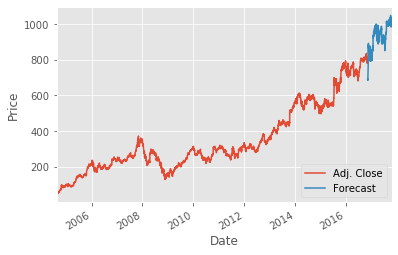

In [12]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()